In [1052]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

debug_level = 0
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Aggregation of all line solutions, represented as statistical distribution 
# 1.0 - always set,  -1.0 - always unset 
class Variants:
    def __init__(self, variants):
        self.aggregate = None
        self.count = 0
        for var in variants:
            if self.aggregate is None:
                self.aggregate = np.zeros((var.sum()))
            self.aggregate += var.unpack()
            self.count += 1
        if self.count:
            self.aggregate /= self.count
    def __repr__(self):
        return f"Variants {self.aggregate}"
        
# Packed representation of one line solution
# Even colums represent unset field, odd colums represent set fields
# [0, 1, 3, 2] represents [.X...XX]
class Variant:
    unpacks_done = 0
    def __init__(self, list):
        self.list = list
        self.unpacked = None
    def __repr__(self):
        return f"Variant {self.str()} {[x for x in self.list]}"
    def str(self):
        out = ""
        for i in self.unpack():
            out += 'X' if i == 1 else '.'
        return out
    def sum(self):
        return sum(self.list)
    # Unpack to array where 1: occupied, 0: empty
    def unpack(self):
        if self.unpacked is None:
            self.unpacked = np.zeros(sum(self.list))
            index = 0
            for i in range(len(self.list)):
                for j in range(self.list[i]):
                    self.unpacked[index] = 1 if i%2 else -1
                    index += 1
            Variant.unpacks_done += 1
        return self.unpacked
    
    # Is compatible with already laid down pieces?
    def can_fit(self, known_pieces):
        if not len(known_pieces): return True
        unpacked = self.unpack()
        for i,j in zip(unpacked, known_pieces):
            if (j+i==0): return False   # unpacked can be only 1 or -1. Zero can happen if the other is opposite
        return True
    
        
# Given specification of one line (row or column). E.g. [1,5,2]
class Seq:
    def __init__(self, list):
        self.list = list
        self.allvariants = None
        self.known_pieces = None
    def __repr__(self):
        return f"Seq {self.list}"
    # partial - partially built list of this combination
    # Note that valid_variants will actually remove the already illegal variants from the cached pool
    def variants(self, width, known_pieces=[], remove_invalid=False, partial=[]):  
        if self.known_pieces is not None:
            for k1, k2 in zip (self.known_pieces, known_pieces):
                if k1 != 0 and k1 != k2:
                    raise Exception("Can't iterate with less known pieces than before, variants were already removed")
        if self.allvariants is None:
            self.allvariants = [variant for variant in self.gather_variants(width, known_pieces, partial) if variant.can_fit(known_pieces)]
            print(f'Generated {len(self.allvariants):>6d} variants for assumed complexity {{{self.variant_count(width)}|{self.variant_discount(width, known_pieces):.1f}}}')

        goodvariants = []
        for variant in self.allvariants:
            if variant.can_fit(known_pieces): 
                yield variant 
                if remove_invalid:
                    goodvariants.append(variant)
        self.known_pieces = np.copy(known_pieces)
        if remove_invalid:
            self.allvariants = goodvariants
            
        
    def gather_variants(self, width, known_pieces, partial=[]):  
        if debug_level > 2: print(f'remain={self.list}, partial={partial}')
        if not Variant(partial).can_fit(known_pieces):
            return
        if not self.list:
            # Successfully emptied all requirements
            finished = Variant(partial + [width - sum(partial)])
            if finished.can_fit(known_pieces):
                yield finished
            return
        # Item that will be placed
        first = self.list[0]
        # Minimum space needed to fit all the remaining ones
        reserved = sum(self.list[1:]) + len(self.list[1:])
        for i in range(0 if not partial else 1, 1 + width - (first + reserved + sum(partial))):
            yield from Seq(self.list[1:]).gather_variants(width, known_pieces, partial + [i, first])
    
    def variant_count(self, width):
        space, needles = (width - (len(self.list)-2 + sum(self.list)), len(self.list))
        if space < 1: return 0
        # print(f'{space=},{needles=}')
        return int(np.math.factorial(space + needles - 1) / (np.math.factorial(space-1) * np.math.factorial(needles)))
    
    # Variant count discounted by the number of known pieces - %SALE %SALE %SALE!
    def variant_discount(self, width, known_pieces):
        if hasattr(known_pieces, '__iter__'): 
            known_pieces = np.count_nonzero(known_pieces)
        return self.variant_count(width) * 0.8**known_pieces  # Definitely not exact. The exact distribution matters here.
         # But we don't need exact, just useful and fast enough to choose the next cheap step!

    # Try the obvious step - if there are known pieces all the way from any border, fill in gaps without getting all the variants
    def fill_obvious(self, width, known_pieces):
        changed, known_pieces = fill_obvious_list(self.list, known_pieces)
        changed_r, known_pieces = fill_obvious_list(self.list[::-1], known_pieces[::-1])
        return changed or changed_r, known_pieces[::-1]
        
def fill_obvious_list(list, known_pieces):
    if not len (list):
        return (False, known_pieces)
    islands = iter(list)
    val = -1  # Currently iterated value
    count = 0 # Number of occurrences so far
    pos = 0   # Position in known_pieces
    did_change = False
    for piece in known_pieces:
        if piece == val:
            # Continue accumulating, still the same
            count += 1
        elif piece == -1 or piece == 1:
            # Different piece
            if piece == -1:
                if not island == count:
                    raise Exception('Invalid combination')
            else:
                island = next(islands)
            val = piece
            count = 1
        else:
            break
        pos += 1
    if val == 1 and island < count:
        raise Exception('Invalid combination')
    # We still have something to fill
    if pos != len(known_pieces) and val == 1:
        while island - count > 0:
            known_pieces[pos] = 1  # Fill rest of the island
            island -= 1
            pos += 1
            did_change = True
        if pos != len(known_pieces):
            known_pieces[pos] = -1  # Needs to terminate with empty
            did_change = True
    return (did_change, known_pieces)
        
        

# Solving matrix
class Field:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.mat = np.zeros((len(self.rows), len(self.cols)))
        self.probs = self.mat.copy() # Probabilities
        self.npass = 0
        self.complexity = 0
        self.more_solutions = False
    def __repr__(self):
        return f'{self.mat}'
    def solve_step(self):
        self.complexity = 0
        while True:
            previous_mat = self.mat.copy()
            row_val, col_val = 1, 0

            # Find the least complex line - sort by complexity. It is only an approximation as also the shape, not just the count of 
            #  known pieces matters here. We're ignoring the shape for simplicity for now.
            lines = [(i,line,row_val,self.mat[i,:]) for i,line in enumerate(self.rows)] + \
                    [(i,line,col_val,self.mat[:,i]) for i,line in enumerate(self.cols)]
            lines = sorted(lines, key = lambda t: t[1].variant_discount(self.mat.shape[t[2]], np.count_nonzero(t[3]))) 
            line_processed = None
       
            for i, line, is_row, known_pieces in lines:
                if line_processed is not None:
                    break # Last line did add some new information, restart from simplest ones
                if not 0 in known_pieces or np.array_equal(line.known_pieces, known_pieces):
                    continue # Already solved or same as before

                length = self.mat.shape[is_row]
                filled, known_pieces = line.fill_obvious(length, known_pieces)
                if filled:
                    print('Did obvious fill')
                    continue # Fill some without generating variants
                variants = Variants(line.variants(length, known_pieces, not self.more_solutions))
                self.complexity += variants.count
                if is_row: self.probs[i,:] = variants.aggregate 
                else: self.probs[:,i] = variants.aggregate
                # print(f'Choosing {line=} with complexity:{line.variant_discount(length, known_pieces)}, {variants=}')
                # print(['{:.0f}'.format(x) for x in known_pieces])

                if variants.aggregate is None:
                    return # There is no solution
                for j in range(len(variants.aggregate)):
                    prob = variants.aggregate[j]
                    if prob == -1 or prob == 1:
                        row = j if not is_row else i
                        col = i if not is_row else j
                        if (self.mat[row,col] != prob):
                            line_processed = line # = ((row, col), (self.mat[row,col], prob))
                            self.mat[row,col] = prob

                self.npass += 1
            if debug_level > 1: print(self.mat)
            changed = (previous_mat != self.mat).any()
            
            # Handle possibility we need to take a guess to continue
            if not changed and not self.is_solved():
                self.more_solutions = True
                guess = copy.copy(self)
                option1, option2 = self.take_a_guess()
                guess.mat = option1
                for advanced in guess.solve_step():
                    self.mat = guess.mat
                    if advanced:
                        yield advanced
                self.complexity += guess.complexity    
                if not self.is_solved():
                    # Guess did not work out, continue with the other option (as long there's only 2)
                    self.mat = option2
                    changed = True
                    
            if not changed:
                break
            yield (True, line_processed)
    
    def take_a_guess(self):
        for i in range(self.mat.shape[0]):
            for j in range(self.mat.shape[1]):
                if self.mat[i,j] == 0:
                    option1 = self.mat.copy()
                    option1[i,j] = 1
                    option2 = self.mat.copy()
                    option2[i,j] = 1
                    return (option1, option2)
    
    def is_solved(self):
        return not 0 in field.mat
    
    def last_complexity(self):
        return self.complexity
    
    def visualize(self):
        fig, ax = plt.subplots(figsize=(2, 8))
        ax.pcolormesh(self.mat, cmap='terrain_r')
        ax.set_aspect('equal')
        ax.set_xlim(0, self.mat.shape[1])
        ax.set_ylim(self.mat.shape[0], 0)
        plt.show()
        
    def visualize_probs(self):
        rows = [0 if row.allvariants is None else 1.0 for row in self.rows]
        rows = np.array(rows)
        rows = rows.reshape(len(rows), 1)
        
        cols = [0 if col.allvariants is None else 1.0 for col in self.cols]
        cols = np.array([0] + cols)
        cols = cols.reshape(1, len(cols))
        
        all = np.concatenate((rows, self.probs), axis=1)
        all = np.concatenate((cols, all), axis=0)
        fig, ax = plt.subplots(figsize=(2, 8))
        ax.pcolormesh(all, cmap='viridis_r')
        ax.set_aspect('equal')
        ax.set_xlim(0, all.shape[1])
        ax.set_ylim(all.shape[0], 0)
        # bx.pcolormesh(rows, cmap='terrain_r')
        plt.show()

In [1053]:
Seq([1,2,3]).fill_obvious(10, [1,-1,1,0,-1,0,0,0,0,1])

(True, [1, -1, 1, 1, -1, 0, -1, 1, 1, 1])

In [1016]:
debug_level = 1
sequence = [1,4,3,1]
vars = Variants(Seq(sequence).variants(30)) # All possibilities
print(f'Variants: {vars}, count: {vars.count}')
vars = Variants(Seq(sequence).variants(30, [0,0,0,0,0,0,0,0,0,1,0])) # All possibilities
print(f'Variants: {vars}, count: {vars.count}')

# print(Variants(Seq([2,1,1]).variants(7, [0, 0, 0, 1, -1, 0, 0 ]))) # Filtered by known pieces
# print(Variants(Seq([2,1,1]).variants(7, [0, 0, 0, 1, -1, -1, -1 ]))) # Filtered by known pieces
# print(Variants(Seq([2,2,2,2,2,5,5,2]).variants(50)))
print(Seq([2,2,2,2,2,5,5,2]).variant_count(50))
[variant for variant in Seq([1,1,1]).variants(7)]

elems = [3, 1, 2, 1]
width = 12
print(len([print(variant) for variant in Seq(elems).variants(width)]))
print(f'VarCount: {Seq(elems).variant_count(width)}')

Generated   7315 variants for assumed complexity {7315|7315.0}
Variants: Variants [-0.64 -0.69 -0.68 -0.63 -0.54 -0.43 -0.34 -0.28 -0.24 -0.21 -0.19 -0.18
 -0.17 -0.17 -0.18 -0.20 -0.22 -0.24 -0.27 -0.30 -0.33 -0.36 -0.40 -0.43
 -0.48 -0.54 -0.63 -0.68 -0.69 -0.64], count: 7315
Generated   2886 variants for assumed complexity {7315|5852.0}
Variants: Variants [-0.65 -0.69 -0.68 -0.64 -0.61 -0.69 -0.38 -0.05 0.34 1.00 0.42 0.04 -0.34
 -0.58 -0.39 -0.32 -0.31 -0.36 -0.39 -0.43 -0.47 -0.50 -0.54 -0.58 -0.62
 -0.67 -0.71 -0.74 -0.74 -0.72], count: 2886
4292145
Generated     10 variants for assumed complexity {10|10.0}
Generated     15 variants for assumed complexity {15|15.0}
Variant XXX.X.XX.X.. [0, 3, 1, 1, 1, 2, 1, 1, 2]
Variant XXX.X.XX..X. [0, 3, 1, 1, 1, 2, 2, 1, 1]
Variant XXX.X.XX...X [0, 3, 1, 1, 1, 2, 3, 1, 0]
Variant XXX.X..XX.X. [0, 3, 1, 1, 2, 2, 1, 1, 1]
Variant XXX.X..XX..X [0, 3, 1, 1, 2, 2, 2, 1, 0]
Variant XXX.X...XX.X [0, 3, 1, 1, 3, 2, 1, 1, 0]
Variant XXX..X.XX.X. [0, 3

In [1017]:
import requests
import re

def get_actual_puzzle(id):
    url = f'https://www.griddlers.net/en_US/nonogram/-/g/t1679057429974/i01?p_p_lifecycle=2&p_p_resource_id=griddlerPuzzle&p_p_cacheability=cacheLevelPage&_gpuzzles_WAR_puzzles_id={id}&_gpuzzles_WAR_puzzles_lite=false'
    r = requests.get(url)
    match = re.search("var puzzle =(.+)\n\nvar solution", r.text, re.DOTALL)
    js_object = match.group(1)
    # replace single quotes with double quotes
    js_object = js_object.replace("'", '"')
    # wrap keys with double quotes
    js_object = re.sub(r"(\w+)\s?:", r'"\1":', js_object)
    # wrap values with double quotes except for numbers or booleans
    js_object = re.sub(r":\s?(?!(\d+|true|false))(\w+)", r':"\2"', js_object)
    # eradicate continuation , on last element in list   <--  hacky, works only on this one ^_^
    js_object = re.sub(r'",\s*\n', r'"\n', js_object)
    barely_json = json.loads(js_object)
    
    # print(barely_json)
    rows = [[row[1] for row in rowses] for rowses in barely_json["leftHeader"]]
    cols = [[col[1] for col in colses] for colses in barely_json["topHeader"]]
    print(f'Downloaded nonogram {id} from the internets with {len(rows)} rows, {len(cols)} cols')
    return rows, cols

def get_test_puzzle(file):
    with open(file) as f:
        data = json.load(f)
    rows = data['rows']
    cols = data['columns']
    return rows, cols

Downloaded nonogram 266162 from the internets with 50 rows, 35 cols
Generated      6 variants for assumed complexity {6|6.0}
step 1, time taken so far: 0.001 s, complexity: 6


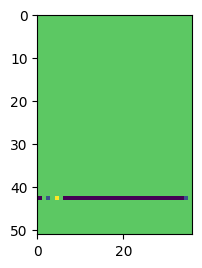

Generated     10 variants for assumed complexity {10|10.0}
Generated     10 variants for assumed complexity {10|10.0}
Generated     10 variants for assumed complexity {10|10.0}
Generated     10 variants for assumed complexity {10|10.0}
Generated     10 variants for assumed complexity {10|10.0}
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Generated     36 variants for assumed complexity {36|36.0}
Generated      5 variants for assumed complexity {15|7.7}
Generated      5 variants for assumed complexity {15|7.7}
Generated     10 variants for assumed complexity {20|12.8}
Generated     10 variants for assumed complexity {20|12.8}
step 11, time taken so far: 0.094 s, complexity: 257


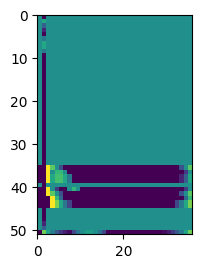

Generated     10 variants for assumed complexity {20|12.8}
Generated     15 variants for assumed complexity {35|14.3}
Generated    210 variants for assumed complexity {462|39.7}
Generated    220 variants for assumed complexity {715|49.1}
Generated    354 variants for assumed complexity {364|61.1}
Generated    120 variants for assumed complexity {120|76.8}
Did obvious fill
Generated    165 variants for assumed complexity {165|105.6}
Generated     46 variants for assumed complexity {210|68.8}
Did obvious fill
Generated   1610 variants for assumed complexity {1820|156.3}
Did obvious fill
Did obvious fill
Generated    354 variants for assumed complexity {364|186.4}
step 21, time taken so far: 0.438 s, complexity: 4531


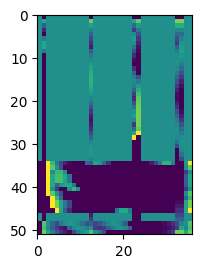

Generated     84 variants for assumed complexity {210|55.1}
Generated    120 variants for assumed complexity {330|69.2}
Generated    126 variants for assumed complexity {210|134.4}
Did obvious fill
Did obvious fill
Generated   2565 variants for assumed complexity {3060|262.9}
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Generated   2541 variants for assumed complexity {6188|425.2}
Generated    126 variants for assumed complexity {252|66.1}
step 31, time taken so far: 0.992 s, complexity: 11458


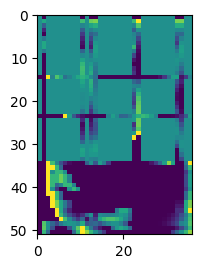

Generated    210 variants for assumed complexity {462|96.9}
Generated    120 variants for assumed complexity {330|108.1}
Generated    120 variants for assumed complexity {330|108.1}
Generated    140 variants for assumed complexity {15504|143.0}
Generated     87 variants for assumed complexity {4495|126.5}
step 41, time taken so far: 1.271 s, complexity: 15930


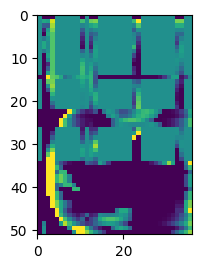

Generated     64 variants for assumed complexity {495|129.8}
Generated    165 variants for assumed complexity {495|202.8}
step 51, time taken so far: 1.418 s, complexity: 19943


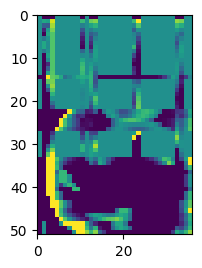

Generated   2221 variants for assumed complexity {8008|180.3}
Generated    228 variants for assumed complexity {455|233.0}
Generated    587 variants for assumed complexity {8855|159.5}
step 61, time taken so far: 2.069 s, complexity: 30307


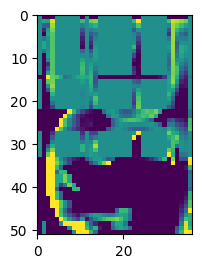

Generated    144 variants for assumed complexity {15504|223.4}
Generated   1732 variants for assumed complexity {19448|280.3}
step 71, time taken so far: 2.583 s, complexity: 33807


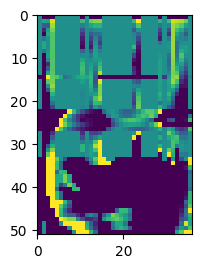

Generated   1100 variants for assumed complexity {27132|250.2}
step 81, time taken so far: 3.029 s, complexity: 39913


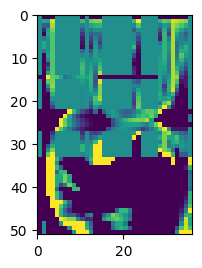

Generated    108 variants for assumed complexity {969|254.0}
step 91, time taken so far: 3.179 s, complexity: 44210


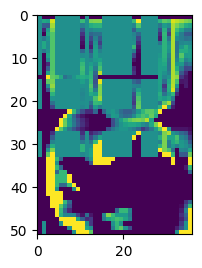

Generated    225 variants for assumed complexity {11628|209.5}
step 101, time taken so far: 3.445 s, complexity: 48934


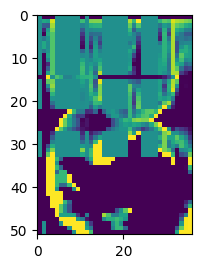

Did obvious fill
Generated    878 variants for assumed complexity {20349|234.6}
Generated     10 variants for assumed complexity {2380|130.8}
step 111, time taken so far: 3.773 s, complexity: 51777


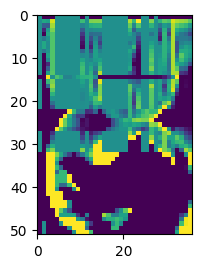

Generated   2833 variants for assumed complexity {27132|312.8}
Did obvious fill
Generated   5314 variants for assumed complexity {31824|366.9}
step 121, time taken so far: 5.247 s, complexity: 64495


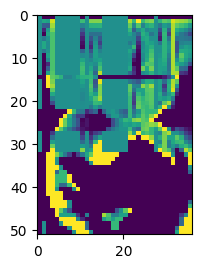

Generated     36 variants for assumed complexity {3060|168.2}
Generated    210 variants for assumed complexity {924|302.8}
Generated    462 variants for assumed complexity {1287|421.7}
Generated    529 variants for assumed complexity {561|448.8}
Did obvious fill
Did obvious fill
Generated   1136 variants for assumed complexity {54264|625.6}
step 131, time taken so far: 5.834 s, complexity: 75123


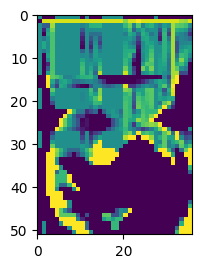

Generated     21 variants for assumed complexity {4845|266.4}
Generated    330 variants for assumed complexity {1716|287.9}
Generated   1642 variants for assumed complexity {54264|625.6}
step 141, time taken so far: 6.317 s, complexity: 79882


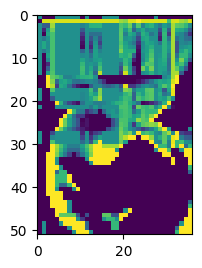

step 151, time taken so far: 6.423 s, complexity: 81260


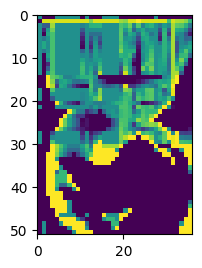

Generated    748 variants for assumed complexity {116280|549.1}
Generated   3574 variants for assumed complexity {18564|653.2}
Generated    176 variants for assumed complexity {134596|635.6}
step 161, time taken so far: 7.372 s, complexity: 94619


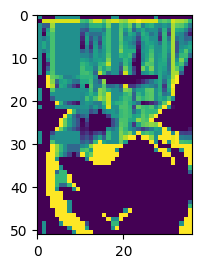

Generated   2557 variants for assumed complexity {116280|686.4}
Did obvious fill
Generated   1287 variants for assumed complexity {50388|907.7}
step 171, time taken so far: 8.881 s, complexity: 107542


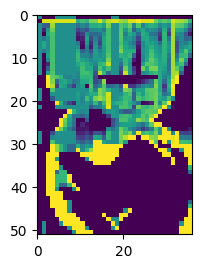

Generated    924 variants for assumed complexity {3003|629.8}
Generated   1100 variants for assumed complexity {100947|931.1}
step 181, time taken so far: 9.406 s, complexity: 114577


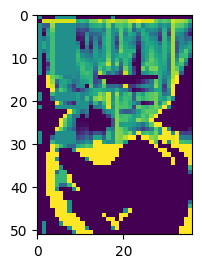

Did obvious fill
Did obvious fill
Generated    792 variants for assumed complexity {50388|1134.6}
Did obvious fill
Did obvious fill
step 191, time taken so far: 10.210 s, complexity: 117224


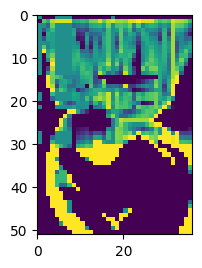

step 201, time taken so far: 10.374 s, complexity: 123413


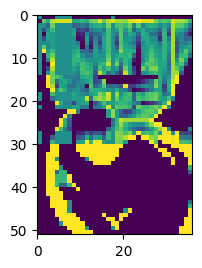

Generated     68 variants for assumed complexity {2380|623.9}
Generated    405 variants for assumed complexity {8008|687.9}
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Generated    165 variants for assumed complexity {278256|841.0}
step 211, time taken so far: 10.768 s, complexity: 127363


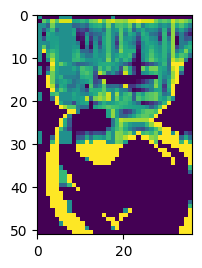

Did obvious fill
Did obvious fill
Generated     12 variants for assumed complexity {38760|357.5}
step 221, time taken so far: 10.891 s, complexity: 129206


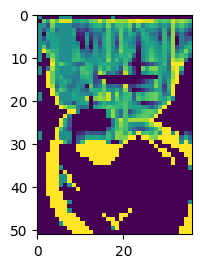

Generated     28 variants for assumed complexity {26334|593.0}
Generated    610 variants for assumed complexity {5005|671.8}
Generated    232 variants for assumed complexity {11440|786.2}
Generated    678 variants for assumed complexity {3003|787.2}
step 231, time taken so far: 11.274 s, complexity: 137472


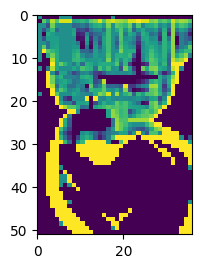

Did obvious fill
Generated    234 variants for assumed complexity {346104|1634.4}
step 241, time taken so far: 11.572 s, complexity: 139078


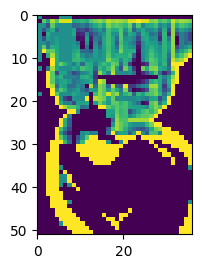

step 251, time taken so far: 11.697 s, complexity: 141724


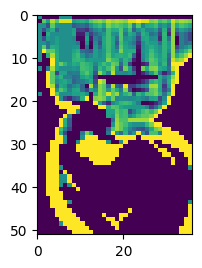

step 261, time taken so far: 11.865 s, complexity: 146033


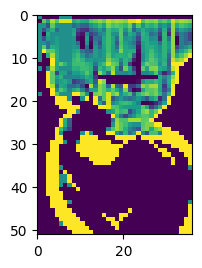

Generated     56 variants for assumed complexity {203490|615.0}
step 271, time taken so far: 12.141 s, complexity: 149195


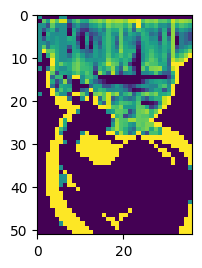

Did obvious fill
Generated    700 variants for assumed complexity {12870|1105.5}
Generated    231 variants for assumed complexity {4368|1145.0}
Generated     55 variants for assumed complexity {1081575|1673.7}
step 281, time taken so far: 12.461 s, complexity: 150794


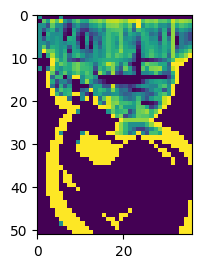

Did obvious fill
Did obvious fill
Did obvious fill
Generated    330 variants for assumed complexity {4292145|4250.7}
Did obvious fill
Generated    312 variants for assumed complexity {11628|1950.9}
Generated  23376 variants for assumed complexity {27405|21924.0}
Generated  12376 variants for assumed complexity {50388|25798.7}
Generated  43758 variants for assumed complexity {75582|60465.6}
Generated  44226 variants for assumed complexity {203490|130233.6}
Generated  43694 variants for assumed complexity {319770|204652.8}
step 291, time taken so far: 25.097 s, complexity: 320092


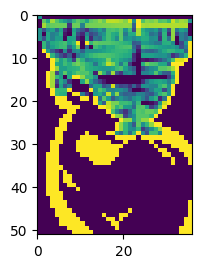

Generated 196860 variants for assumed complexity {497420|397936.0}
Generated 118755 variants for assumed complexity {593775|475020.0}
step 301, time taken so far: 69.396 s, complexity: 742967


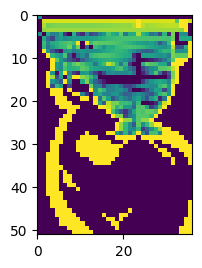

Did obvious fill
Generated   9216 variants for assumed complexity {1562275|511926.3}
Did obvious fill
step 311, time taken so far: 75.319 s, complexity: 873038


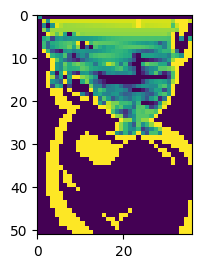

Did obvious fill
step 321, time taken so far: 77.334 s, complexity: 975615


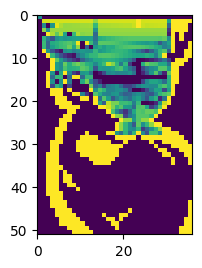

step 331, time taken so far: 77.442 s, complexity: 976810


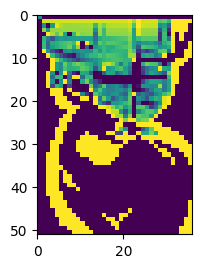

step 341, time taken so far: 77.578 s, complexity: 979949


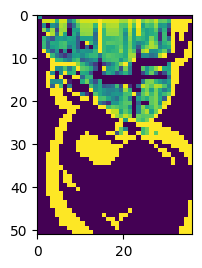

step 351, time taken so far: 77.671 s, complexity: 980201


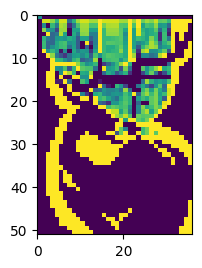

Did obvious fill
step 361, time taken so far: 77.780 s, complexity: 981847


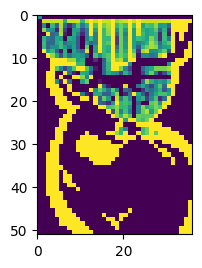

step 371, time taken so far: 77.874 s, complexity: 982584


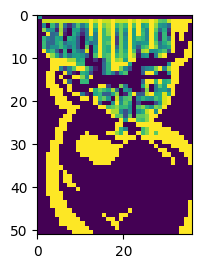

step 381, time taken so far: 77.964 s, complexity: 982786


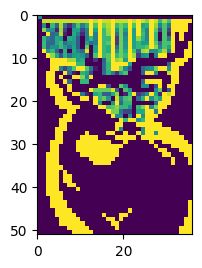

Did obvious fill
Did obvious fill
Did obvious fill
step 391, time taken so far: 78.052 s, complexity: 982872


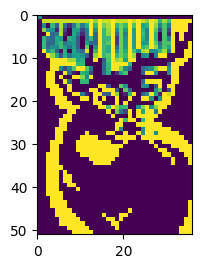

Did obvious fill
Did obvious fill
step 401, time taken so far: 78.143 s, complexity: 982965


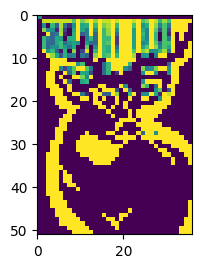

step 411, time taken so far: 78.234 s, complexity: 983087


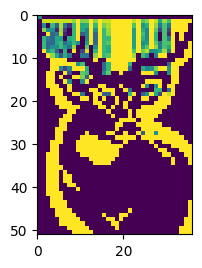

step 421, time taken so far: 78.325 s, complexity: 983468


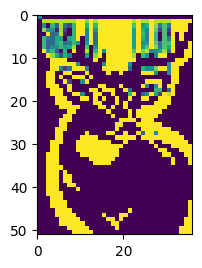

Did obvious fill
Did obvious fill
Did obvious fill
step 431, time taken so far: 78.414 s, complexity: 983694


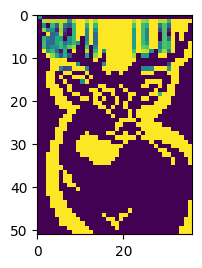

step 441, time taken so far: 78.513 s, complexity: 983876


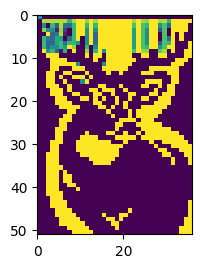

Did obvious fill
step 451, time taken so far: 78.624 s, complexity: 984201


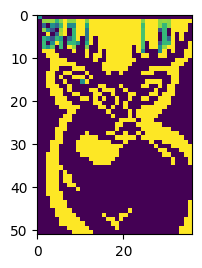

step 461, time taken so far: 78.740 s, complexity: 984299


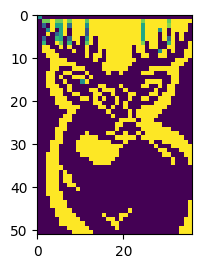

Did obvious fill
Did obvious fill
Did obvious fill
step 471, time taken so far: 78.986 s, complexity: 984360


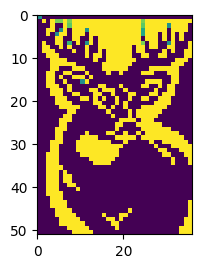

Did obvious fill
Did obvious fill
Did obvious fill
Did obvious fill
Solved in 480 steps :-)
 took 79.106 s
Variant.unpacks_done=3669413 (the expensive stuff)


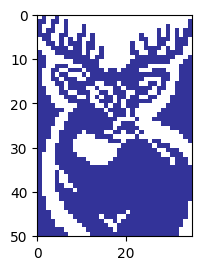

In [1018]:
# Load our next puzzle
# rows, cols = get_test_puzzle('gridler.multisolve.json.txt')
rows, cols = get_actual_puzzle(266162)

srows = [Seq(row) for row in rows]
scols = [Seq(col) for col in cols]
field = Field(srows, scols)

prev = start
step = 0
debug_level = 0
Variant.unpacks_done = 0
start = time.perf_counter()

# Fire the solver
for advanced, processed in field.solve_step():
    step += 1
    if step % 10 == 1:
        print(f'step {step}, time taken so far: {time.perf_counter() - start:.3f} s, complexity: {field.last_complexity()}')
        field.visualize_probs()
    prev = time.perf_counter()
    if not advanced:
        break

if not field.is_solved():
    print("No possible solutions :-(  (or just can't solve them :)")
else:
    print(f"Solved in {step} steps :-)") 
    if field.more_solutions: print(f"There are multiple possible solutions and this is just one of them")
print(f" took {time.perf_counter() - start:.3f} s")
print(f"{Variant.unpacks_done=} (the expensive stuff)")
field.visualize()

# Current state:
#  Still No branching support 